# Lending Case Club Study

## Brief

Lending Club is a consumer finance company which specializes in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:

- If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company
- If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company

## Business Objective 

Lending Club wants to understand the driving factors behind loan default, i.e. the driver variables which are strong indicators of default. The company can utilize this knowledge for its portfolio and risk assessment.

Objective is to identify the risky loan applicants at the time of loan application so that such loans can be reduced thereby cutting down the amount of credit loss. Identification of such applicants using EDA is the aim of this case study.

To understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default. The company can utilise this knowledge for its portfolio and risk assessment. And thus minimise the risk of losing money while lending to customers.

### Target Variable

##### Target Variable - 'Loan Status' based on the business explanation in objective




<a id="01" style="color:Blue; font-size: 24px;">Import Libraries and set required parameters</a>

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option("display.Max_columns", 500)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
rcParams['figure.figsize'] = 14,7
plt.style.use("fivethirtyeight")

## <a id="02" style="color:Blue; font-size: 24px;">Data Sourcing</a>

In [2]:
df = pd.read_csv('loan.csv',encoding = "ISO-8859-1", low_memory=False)
print(df.shape)
#df.head()

(39717, 111)


In [3]:
meta_df=pd.read_excel("Data_Dictionary.xlsx", engine='openpyxl')
meta_df.set_index(meta_df["LoanStatNew"], inplace=True)
#meta_df = meta_df.loc[:, ~meta_df.columns.str.contains('^Unnamed')]
print(meta_df.columns)
#meta_df.head()

Index(['LoanStatNew', 'Description', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10'],
      dtype='object')


## <a id="03" style="color:Blue; font-size: 24px;">Functions</a>

In [4]:
# Function displaying meta data for each olumn with its description from data dictionary
def qck(df):
    #pd.set_option("display.Max_rows", None)
    print(f"loan Dim: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary['Name'] = summary.index
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Missing%'] = 100*df.isnull().sum().values/len(df.index)
    summary['Uniques'] = df.nunique().values 
    flt=meta_df["LoanStatNew"].isin(df.columns)
    meta_df1=meta_df.loc[flt]
    summary=pd.merge(summary, meta_df1, left_index=True, right_index=True)
    summary.sort_index(inplace=True)
    summary.drop(columns=["Name","LoanStatNew"], axis=1, inplace=True)
    return summary
    #pd.reset_option('display.max_rows')

# Function for dropping columns with given threshold percentage of null values
def drop_null_col(df, per):
    for i in df.columns:
        if(100*df[i].isnull().sum()/len(df.index)>=per):
            print(i)
            df.drop(columns=i, axis=1, inplace=True)
    print(": Columns Removed")

# Function plotting for univariate variable based on variale types
def uv(df,col,vartype,hue =None):  
    
    if vartype == 0:
        plt.style.use("seaborn")
        plt.figure(figsize=(10, 4)) 
        ax1=plt.subplot(1,3,1)
        ax1=sns.distplot(col)
        ax1.set_title("Distribution Plot")
        ax2=plt.subplot(1,3,2)
        ax2=sns.violinplot(data =df, x=col, inner="quartile")
        ax2.set_title("Violin Plot")
        ax3=plt.subplot(1,3,3)
        ax3=sns.boxplot(data =df, x=col, orient='v')
        ax3.set_title("Box Plot")
        
    
    elif vartype == 1:
        plt.style.use("fivethirtyeight")
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots(figsize = (10, 4))
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        #fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(df))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
    plt.tight_layout()    
    plt.show()

# Dictionary storing information content as value and key as variable name
information_content=dict()

# FUnction plotting default rate of categorical variables
def grf2(df1, xxx, col,fig_w):
    a_min=[]
    b_max=[]
    c_dif=[]
    d_grp=[]
    plt.figure(figsize = (15, fig_w))
    plt.style.use("fivethirtyeight")
    c=0
    for i in xxx:
        c=c+1
        plt.subplot(len(xxx)/col,col,c)
        #gg=sns.color_palette("magma", as_cmap=True)
        ndf=df1.groupby([i])['z_loan_status'].mean().rename('Avg').reset_index()
        a_min.append(round(ndf.Avg.min(), 2))
        b_max.append(round(ndf.Avg.max(), 2)) 
        c_dif.append(round(ndf.Avg.max(), 2)-round(ndf.Avg.min(), 2)) 
        d_grp.append(f"Default Rate".upper() + f" (Based On "+f" {i})".upper())
        gg=sns.barplot(data=ndf, x=i, y="Avg",estimator=np.mean)
        gg.set_xticklabels(gg.get_xticklabels(),rotation=90, fontsize=11)
        gg.set_title(f"Default Rate".upper() + f" (Based On "+f" {i})".upper(), fontsize=16)
        gg.set_xlabel(i, fontsize=14)
        gg.set_ylabel("Default Rate", fontsize=14)
        plt.tight_layout()
        for p in gg.patches:
            gg.annotate(format(p.get_height(), '.2f') , 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       size=12,
                       xytext = (0, +8), 
                       textcoords = 'offset points')
        information_content[i]=round(ndf.Avg.max(), 2)-round(ndf.Avg.min(), 2)
        comp_df=pd.DataFrame({"Feature":d_grp,"Max":b_max,"Min":a_min,"Diff":c_dif})
        comp_df=comp_df.sort_values(by="Diff", ascending=False)
    
    print(comp_df)       
    plt.show()

# Function showing bar text
def BarShowText(gg):
     for p in gg.patches:  
      gg.annotate(format(round(p.get_height()), '.2f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       size=12,
                       xytext = (0, +8), 
                       textcoords = 'offset points')

# Function plotting default rate on bar plot with two other categorical variables
def default_rate_bivariate(df,col1,col2):
    gg=sns.barplot(data=df, x=col1, y="z_loan_status",hue=col2,estimator=np.mean,ci=None)
    gg.set_xticklabels(gg.get_xticklabels(),rotation=90, fontsize=11)
    gg.set_title(f"Default Rate", fontsize=16)
    gg.set_ylabel("Default Rate", fontsize=14)
    plt.tight_layout()
    for p in gg.patches:
        gg.annotate(format(p.get_height(), '.2f') , 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, +8), 
                   textcoords = 'offset points')
    plt.show()

In [5]:
sdf=qck(df)
sdf

loan Dim: (39717, 111)


,dtypes,Missing,Missing%,Uniques,Description,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
acc_now_delinq,int64,0,0.0,1,The number of accounts on which the borrower is now delinquent.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acc_open_past_24mths,float64,39717,100.0,0,Number of trades opened in past 24 months.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
addr_state,object,0,0.0,50,The state provided by the borrower in the loan application,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
all_util,float64,39717,100.0,0,Balance to credit limit on all trades,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,float64,0,0.0,5318,The self-reported annual income provided by the borrower during registration.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
total_rec_late_fee,float64,0,0.0,1356,Late fees received to date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rec_prncp,float64,0,0.0,7976,Principal received to date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
url,object,0,0.0,39717,URL for the LC page with listing data.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
verification_status,object,0,0.0,3,"Indicates if income was verified by LC, not verified, or if the income source was verified",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,14035.000000,2786.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39661.0,0.0,39717.0,0.0,0.0,0.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39661.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39020.000000,39678.0,0.0,0.0,0.0,0.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,35.900962,69.698134,9.294408,0.055065,13382.528086,22.088828,51.227887,50.989768,12153.596544,11567.149118,9793.348813,2263.663172,1.363015,95.221624,12.406112,2678.826162,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043260,0.0,NaN,NaN,NaN,NaN
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,22.020060,43.822529,4.400282,0.237200,15885.016641,11.401709,375.172839,373.824457,9042.040766,8942.672613,7065.522127,2608.111964,7.289979,688.744771,148.671593,4447.136012,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204324,0.0,NaN,NaN,NaN,NaN
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,18.000000,22.000000,6.000000,0.000000,3703.000000,13.000000,0.000000,0.000000,5576.930000,5112.310000,4600.000000,662.180000,0.000000,0.000000,0.000000,218.680000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [7]:
df.columns.sort_values()

Index(['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util',
       'annual_inc', 'annual_inc_joint', 'application_type', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util',
       ...
       'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'total_rev_hi_lim', 'url', 'verification_status',
       'verification_status_joint', 'zip_code'],
      dtype='object', length=111)

## <a id="04" style="color:Blue; font-size: 24px;">Handling Missing Value -- Cleaning -- Manipulation</a>

### Dropping all columns have missing value 90% or greater

In [8]:
drop_null_col(df,90)

mths_since_last_record
next_pymnt_d
mths_since_last_major_derog
annual_inc_joint
dti_joint
verification_status_joint
tot_coll_amt
tot_cur_bal
open_acc_6m
open_il_6m
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_bc_dlq
mths_since_recent_inq
mths_since_recent_revol_delinq
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_accts
num_rev_tl_bal_gt_0
num_sats
num_tl_120dpd_2m
num_tl_30dpd
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
percent_bc_gt_75
tot_hi_cred_lim
total_bal_ex_mort
total_bc_limit
total_il_high_credit_limit
: Columns Removed


In [9]:
sdf=qck(df)
sdf[(sdf['Missing']!=0)].sort_index().head(50)

loan Dim: (39717, 55)


,dtypes,Missing,Missing%,Uniques,Description,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
chargeoff_within_12_mths,float64,56,0.140998,1,Number of charge-offs within 12 months,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
collections_12_mths_ex_med,float64,56,0.140998,1,Number of collections in 12 months excluding medical collections,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
desc,object,12940,32.580507,26527,Loan description provided by the borrower,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,object,1075,2.706650,11,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_title,object,2459,6.191303,28820,The job title supplied by the Borrower when applying for the loan.*,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_credit_pull_d,object,2,0.005036,106,The most recent month LC pulled credit for this loan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_pymnt_d,object,71,0.178765,101,Last month payment was received,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mths_since_last_delinq,float64,25682,64.662487,95,The number of months since the borrower's last delinquency.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pub_rec_bankruptcies,float64,697,1.754916,3,Number of public record bankruptcies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revol_util,object,50,0.125891,1089,"Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Now for Analysis purpose the listed column is not much effective, also the have high ammount of missing value, so they can be dropped: Such Columns are

***desc***: This will not impact our analysis and also we have another variable named purpose which tells about the categorey provided by borrower.

***last_credit_pull_d:*** This columns is kind of be behavioural variable for customer which is applicable after disbursment of the loan. So this is not required for our analysis.

***last_pymnt_d:*** This columns represents the behavioural variable for customer which is applicable after disbursment of the loan. So this is not required for our analysis.

***mths_since_last_delinq*** This columns is not required for analysis.

***revol_util*** This column is also comes into the picture once loan is disbursed.

***revol_bal*** This column is also comes into the picture once loan is disbursed.

***title*** This columns is not required for analysis.

***tax_liens*** This columns is not required for analysis.

***chargeoff_within_12_mths*** This columns represents the behavioural variable for customer which is applicable after disbursment of the loan. So this is not required for our analysis.

***collections_12_mths_ex_med*** This columns represents the behavioural variable for customer which is applicable after disbursment of the loan. So this is not required for our analysis.


In [10]:
null_lst=['desc','last_credit_pull_d','revol_util','revol_bal','last_pymnt_d','mths_since_last_delinq',"title","tax_liens","chargeoff_within_12_mths","collections_12_mths_ex_med"]
df.drop(null_lst, axis=1, inplace=True)

In [11]:
sdf=qck(df)
sdf[(sdf['Missing']!=0)].sort_index().head(50)

loan Dim: (39717, 45)


,dtypes,Missing,Missing%,Uniques,Description,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
emp_length,object,1075,2.706650,11,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_title,object,2459,6.191303,28820,The job title supplied by the Borrower when applying for the loan.*,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pub_rec_bankruptcies,float64,697,1.754916,3,Number of public record bankruptcies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In case of 'emp_length' & 'Emp_title' we can drop the rows those contain null values

In [12]:
df.dropna(axis=0, how="any", inplace=True)

In [13]:
sdf=qck(df)
sdf[(sdf['Missing']!=0)].sort_index().head(50)

loan Dim: (36548, 45)


,dtypes,Missing,Missing%,Uniques,Description,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10


### Further we can reduce the dimension of dataframe by excempting some more useless columns mentioned below
***id :*** is a random number given to the loan, does not contribute to analysis<br>
***member_id :*** is a random number given to the member, does not contribute to analysis<br>
***url :*** is a URL for LC page for corresponding to each memberid, nothing to do with loan default.<br>
***zip_code :*** This column does not influence the analysis. we have  othe same type of demographic column named "addr_state"<br>
***funded_amnt :*** value for this column is almost equivalent to loan_amnt. removing to avoid multi colinearity (observed using correlation marix).<br>
***funded_amnt_inv :*** value for this column is almost equivalent to funded_amnt (observed using correlation marix), removing to avoid multi colinearity. Also this wont be available at the time of decision making of funding a loan.


In [14]:
null_lst=['id','member_id','url','zip_code',"funded_amnt","funded_amnt_inv"]
df.drop(null_lst, axis=1, inplace=True)
df.shape

(36548, 39)

In [15]:
df.columns.sort_values()

Index(['acc_now_delinq', 'addr_state', 'annual_inc', 'application_type',
       'collection_recovery_fee', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'earliest_cr_line', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'initial_list_status', 'inq_last_6mths',
       'installment', 'int_rate', 'issue_d', 'last_pymnt_amnt', 'loan_amnt',
       'loan_status', 'open_acc', 'out_prncp', 'out_prncp_inv', 'policy_code',
       'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'pymnt_plan',
       'recoveries', 'sub_grade', 'term', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'verification_status'],
      dtype='object')

### Removing rows having value "current" in loan_status Column

In [16]:
df=df[~(df.loan_status=='Current')]
df.shape

(35482, 39)

### Now there is no null value, but we can reduce the dimension of dataframe by excempting the columns having identical values.

In [17]:
unique_flt=(sdf["Uniques"]==1)
uniq_col_flt=sdf[unique_flt].index
df.drop(uniq_col_flt, axis=1, inplace=True)
df.shape

(35482, 33)

### Derive "loan_status"  numeric column for easy calculatyion

In [18]:
df["z_loan_status"]=df['loan_status']
loan_status_dict={'Fully Paid':0, 'Charged Off':1}
df = df.replace({"z_loan_status": loan_status_dict })

### Replacing emp_length to numreic values

In [19]:
emp_length_dict = {
    '< 1 year' : 0,
    '1 year' : 1,
    '2 years' : 2,
    '3 years' : 3,
    '4 years' : 4,
    '5 years' : 5,
    '6 years' : 6,
    '7 years' : 7,
    '8 years' : 8,
    '9 years' : 9,
    '10+ years' : 10
}

df = df.replace({"emp_length": emp_length_dict })

### <span style="color:orange">11>  Stripping "%"</span>

In [20]:
df.int_rate=df.int_rate.str.strip("%").astype('float')
#df.revol_util=df.revol_util.str.strip("%").astype('float')
#df.int_rate

### <span style="color:orange">12>  Cast all continuos variables to numeric</span>

In [21]:
sdf=qck(df)
flt=sdf.index.isin( ['loan_amnt','funded_amnt','funded_amnt_inv','installment','int_rate','annual_inc','dti','total_pymnt','total_rec_late_fee','collection_recovery_fee'])
sdf[flt]


loan Dim: (35482, 34)


,dtypes,Missing,Missing%,Uniques,Description,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
annual_inc,float64,0,0.0,4842,The self-reported annual income provided by the borrower during registration.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
collection_recovery_fee,float64,0,0.0,2410,post charge off collection fee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dti,float64,0,0.0,2842,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
installment,float64,0,0.0,14067,The monthly payment owed by the borrower if the loan originates.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,float64,0,0.0,334,Interest Rate on the loan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,int64,0,0.0,848,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_pymnt,float64,0,0.0,33840,Payments received to date for total amount funded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rec_late_fee,float64,0,0.0,1166,Late fees received to date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## <a id="04" style="color:Blue; font-size: 24px;">Derived Metrices</a>

### <span style="color:orange">1> Loan Amount to Income ratio.</span>

In [22]:
df['loan_income_ratio']= df['loan_amnt']/df['annual_inc']

### <span style="color:orange">2> Extracting Year & Month from Issue date.</span>

In [23]:
df[["z_iss_m","z_iss_y"]]=df["issue_d"].str.split("-",expand=True)

### <span style="color:orange">3> Arranging "z_iss_m" in ascending order as it is ordered categorial variables.</span>

In [24]:
months_order = ["Jan", "Feb", "Mar", "Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
df['z_iss_m'] = pd.Categorical(df['z_iss_m'],categories=months_order, ordered=True)
df.head(2)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies,z_loan_status,loan_income_ratio,z_iss_m,z_iss_y
1,2500,60 months,15.27,59.83,C,C4,Ryder,0,RENT,30000.0,Source Verified,Dec-11,Charged Off,car,GA,1.0,0,Apr-99,5,3,0,4,0.0,0.0,1008.71,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,1,0.083333,Dec,11
3,10000,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10,RENT,49200.0,Source Verified,Dec-11,Fully Paid,other,CA,20.0,0,Feb-96,1,10,0,37,0.0,0.0,12231.89,12231.89,10000.00,2214.92,16.97,0.00,0.00,357.48,0.0,0,0.203252,Dec,11


### <span style="color:orange">4> Create Bins for range of Loan Amount.</span>

In [25]:
bins = [0, 5000, 10000, 15000, 20000, 25000,40000]
slot = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000 and above']
df['z_loan_amnt'] = pd.cut(df['loan_amnt'], bins, labels=slot)

### <span style="color:orange">5> Create Bins for range of Annual Income.</span>

In [26]:
bins = [0, 25000, 50000, 75000, 100000,1000000]
slot = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 and above']
df['z_annual_inc'] = pd.cut(df['annual_inc'], bins, labels=slot)

### <span style="color:orange">6> Create Bins for range of interest rate.</span>

In [27]:

bins = [0, 7.5, 10, 12.5, 15,20]
slot = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15 and above']
df['z_int_rate'] = pd.cut(df['int_rate'], bins, labels=slot)
#df['int_rate_bins']= round(df.int_rate)


### <span style="color:orange">7> Create Bins for range of DTI.</span>

In [28]:
bins=[0,5,10,15,20,25,30]
slot=['0-5','5-10','10-15','15-20','20-25','25-30']
df['z_dti'] = pd.cut(df['dti'], bins=bins, labels=slot)

## UV Analysis

### The Key Feature - loan_status

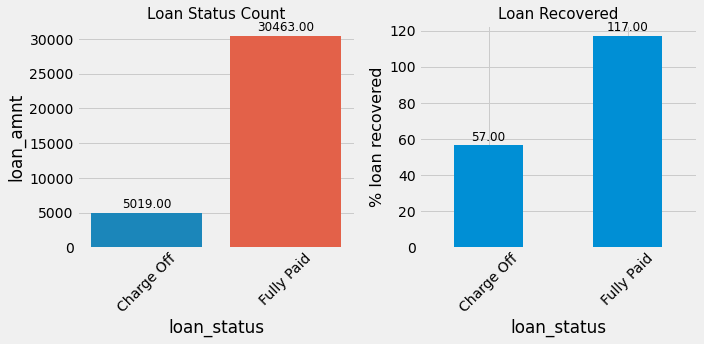

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ndf = df.groupby('loan_status').loan_amnt.count().reset_index()
gg0=sns.barplot(data=ndf, x='loan_status',y='loan_amnt')
gg0.set_xticklabels(['Charge Off',"Fully Paid"], rotation=45)
gg0.set_xlabel('loan_status')
gg0.set_title("Loan Status Count", fontsize=15)
BarShowText(gg0)

plt.subplot(1,2,2)
gg1 = (df.groupby('loan_status').total_pymnt.sum() * 100 / df.groupby('loan_status').loan_amnt.sum()).plot.bar()
gg1.set_ylabel('% loan recovered', fontsize=16)
gg1.set_xticklabels(['Charge Off', "Fully Paid"], rotation=45)
gg1.set_xlabel('loan_status')
gg1.set_title("Loan Recovered", fontsize=15)
BarShowText(gg1)
plt.tight_layout()
plt.show()

In [30]:
#print("%.2f" % (df.loc[df['z_loan_status'] == 1].z_loan_status.count() * 100/len(df)))
print("%.2f" % (df.loc[df['loan_status'] == "Charged Off"].loan_status.count() * 100/len(df)))

14.15


### UV Analysis:- 1>Annual Income

In [31]:
df["annual_inc"].describe()

count    3.548200e+04
mean     6.902437e+04
std      6.392552e+04
min      4.000000e+03
25%      4.124625e+04
50%      6.000000e+04
75%      8.230000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

***6000000 is the max value which is approx 87 times more than mean value, so we will remove the outliers from Annual Income.
Remove Outliers (values from 99 to 100%)***

In [32]:
q = df["annual_inc"].quantile(0.995)
df = df[df["annual_inc"] < q]
df["annual_inc"].describe()

count     35292.000000
mean      66516.689692
std       36688.684551
min        4000.000000
25%       41000.000000
50%       59418.000000
75%       82000.000000
max      294000.000000
Name: annual_inc, dtype: float64

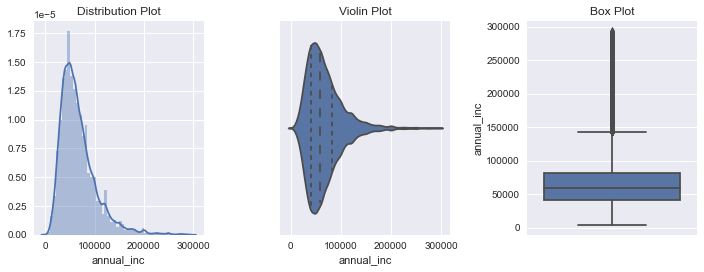

In [33]:
uv(df,df.annual_inc,0)

***Remarks: Most of the applicants earns beteen 40000 to 90000 USD annually.***

In [34]:
df.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,4999.0,12202.355471,8057.966022,1000.0,6000.0,10000.0,16800.0,35000.0
Fully Paid,30293.0,10896.343215,7137.930828,500.0,5400.0,9600.0,15000.0,35000.0


                                 Feature   Max   Min  Diff
0  DEFAULT RATE (Based On  Z_ANNUAL_INC)  0.19  0.11  0.08


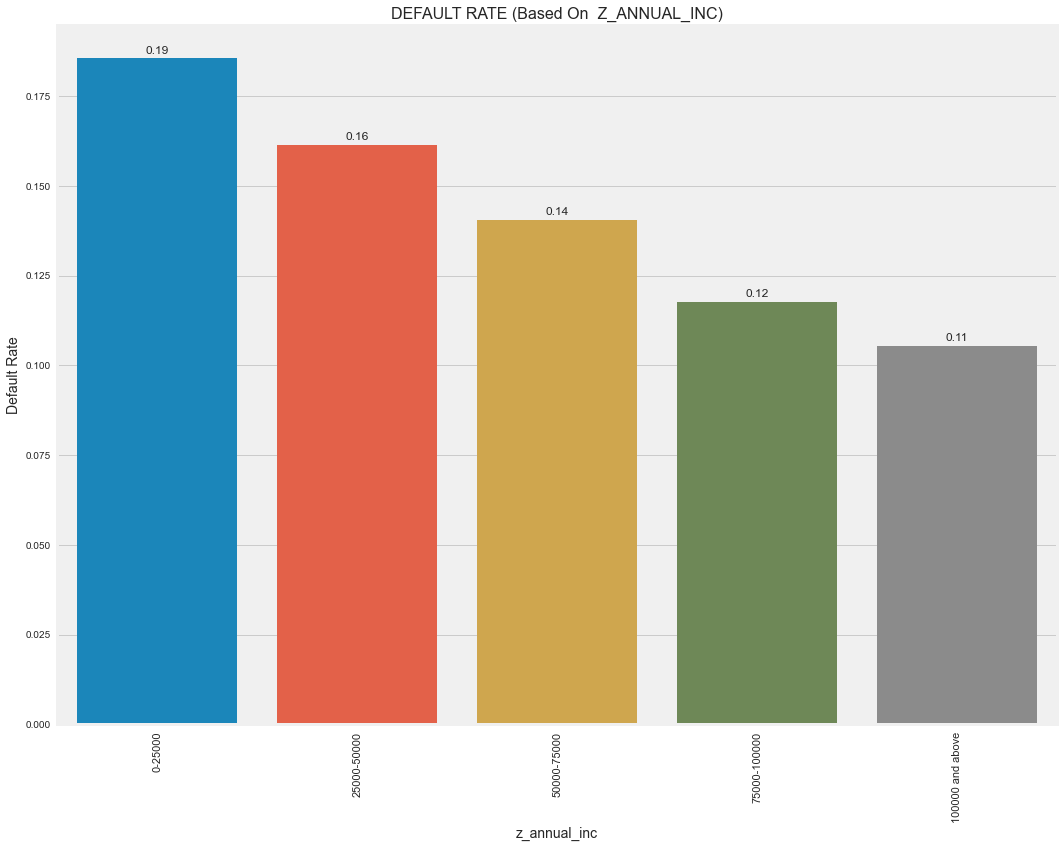

In [35]:
grf2(df,['z_annual_inc'],1,12)

***Remarks- As the annual income increases it lowers the risk of getting deafult loans***

### UV Analysis:- 2> Interest Rate:

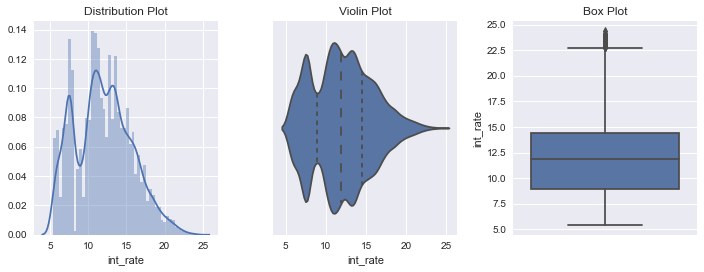

In [36]:
uv(df,df.int_rate, 0)

**Remarks: Most of the loans interest rates are distributed between 8% to 15%.**

                               Feature   Max   Min  Diff
0  DEFAULT RATE (Based On  Z_INT_RATE)  0.24  0.04   0.2


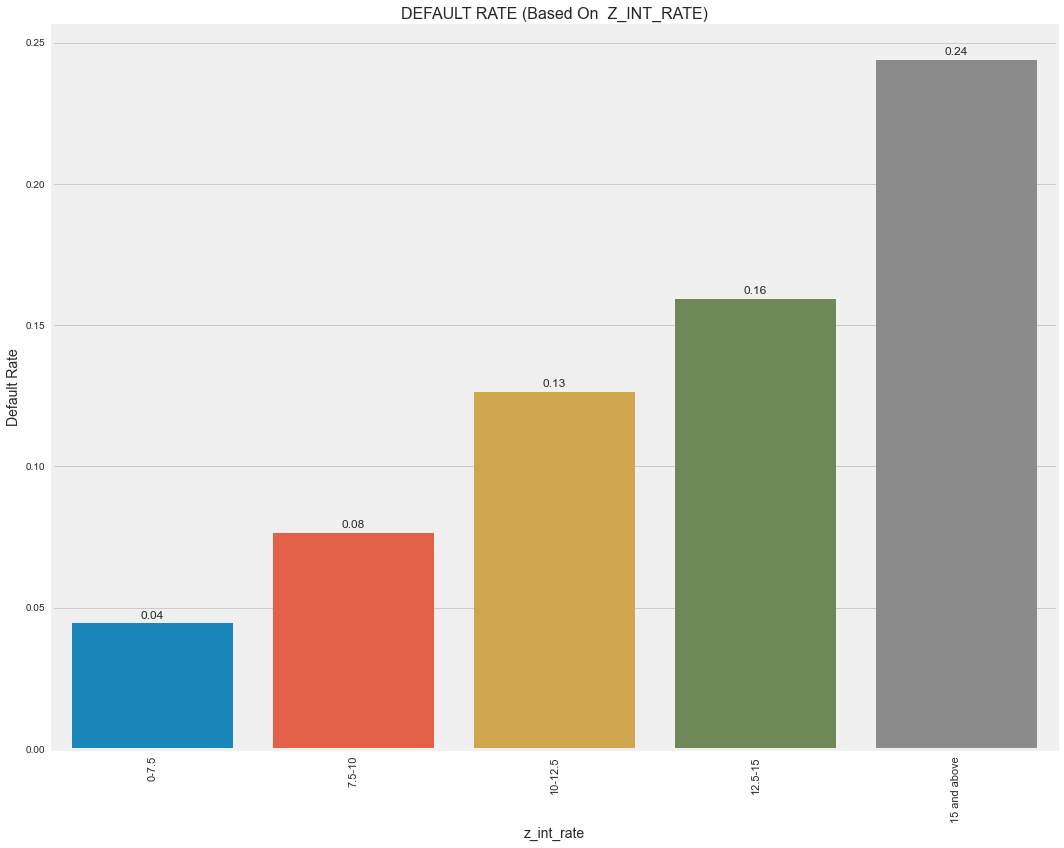

In [37]:
grf2(df,['z_int_rate'],1,12)

### UV Analysis:- 3>loan_amount

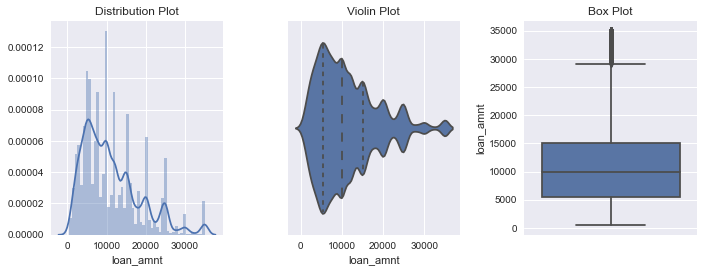

In [38]:
uv(df, df.loan_amnt, 0)

                                Feature   Max   Min  Diff
0  DEFAULT RATE (Based On  Z_LOAN_AMNT)  0.23  0.12  0.11


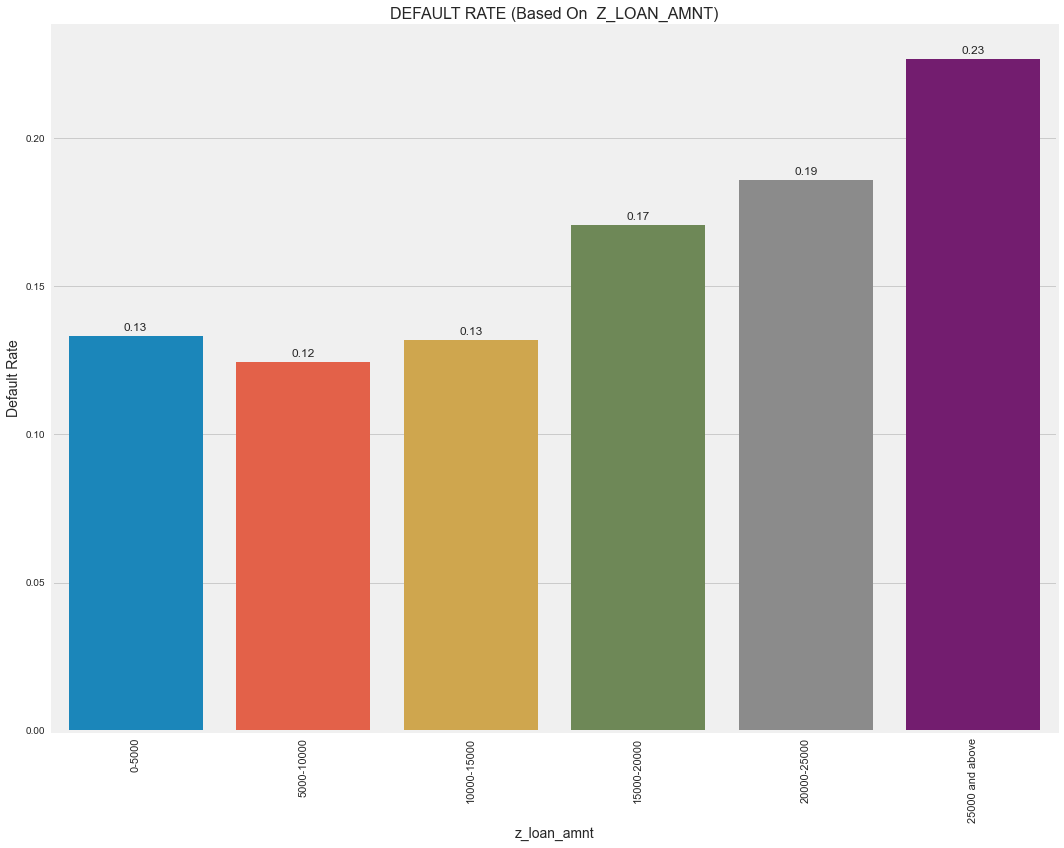

In [39]:
lst2=["z_loan_amnt"]
grf2(df,lst2,1, 12)

**<span style="color:blue">Remarks: In maximum cases the loan amounts are distributed between 6000 to 16000 USD. As the loan amount increases risk of loan to be default also increases</span>**

                                         Feature   Max   Min  Diff
0                 DEFAULT RATE (Based On  GRADE)  0.34  0.06  0.28
5  DEFAULT RATE (Based On  PUB_REC_BANKRUPTCIES)  0.40  0.14  0.26
1               DEFAULT RATE (Based On  PURPOSE)  0.27  0.10  0.17
4                  DEFAULT RATE (Based On  TERM)  0.25  0.11  0.14
2        DEFAULT RATE (Based On  HOME_OWNERSHIP)  0.19  0.13  0.06
3   DEFAULT RATE (Based On  VERIFICATION_STATUS)  0.16  0.12  0.04


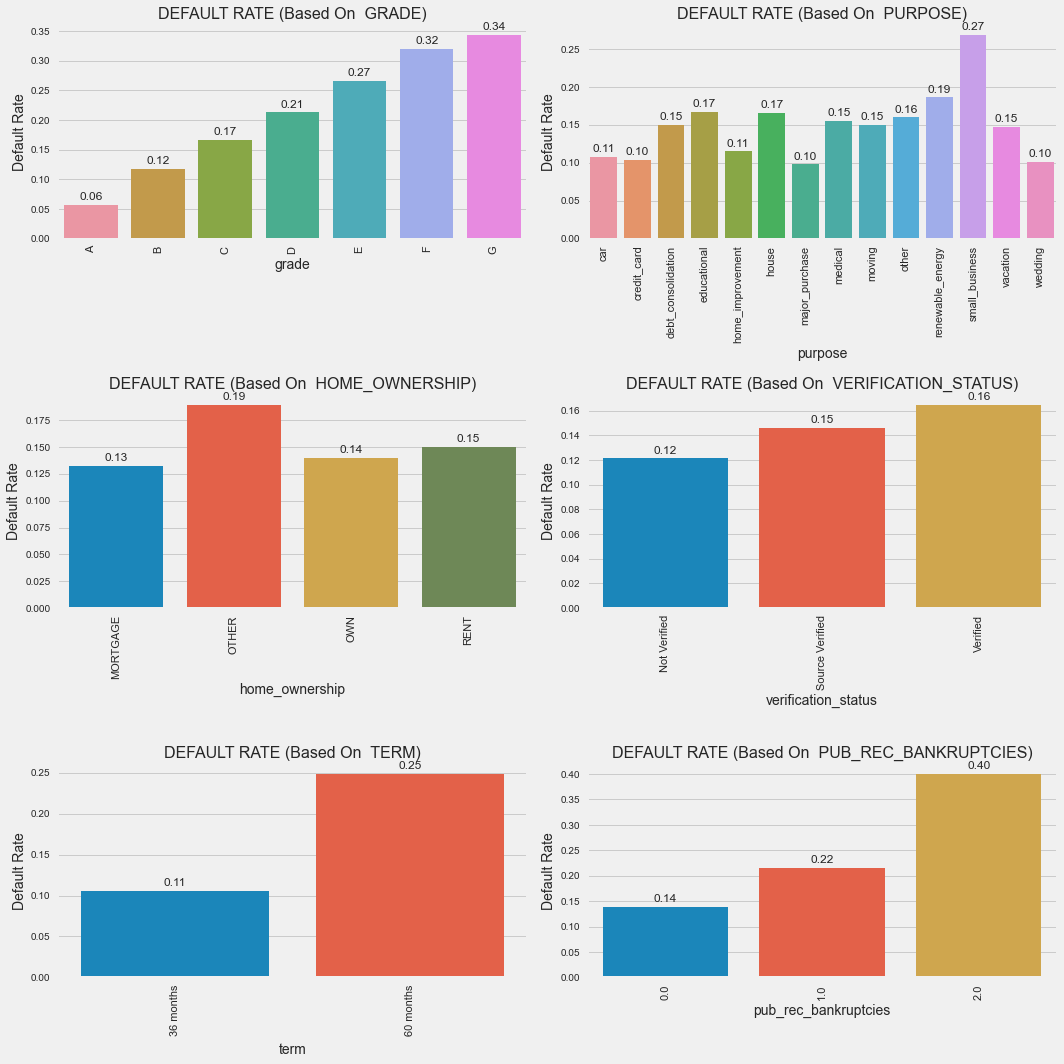

In [40]:
lst=["grade","purpose","home_ownership", 'verification_status','term','pub_rec_bankruptcies']
grf2(df,lst,2.,15)

                              Feature   Max   Min  Diff
0  DEFAULT RATE (Based On  SUB_GRADE)  0.47  0.02  0.45
1      DEFAULT RATE (Based On  Z_DTI)  0.16  0.12  0.04


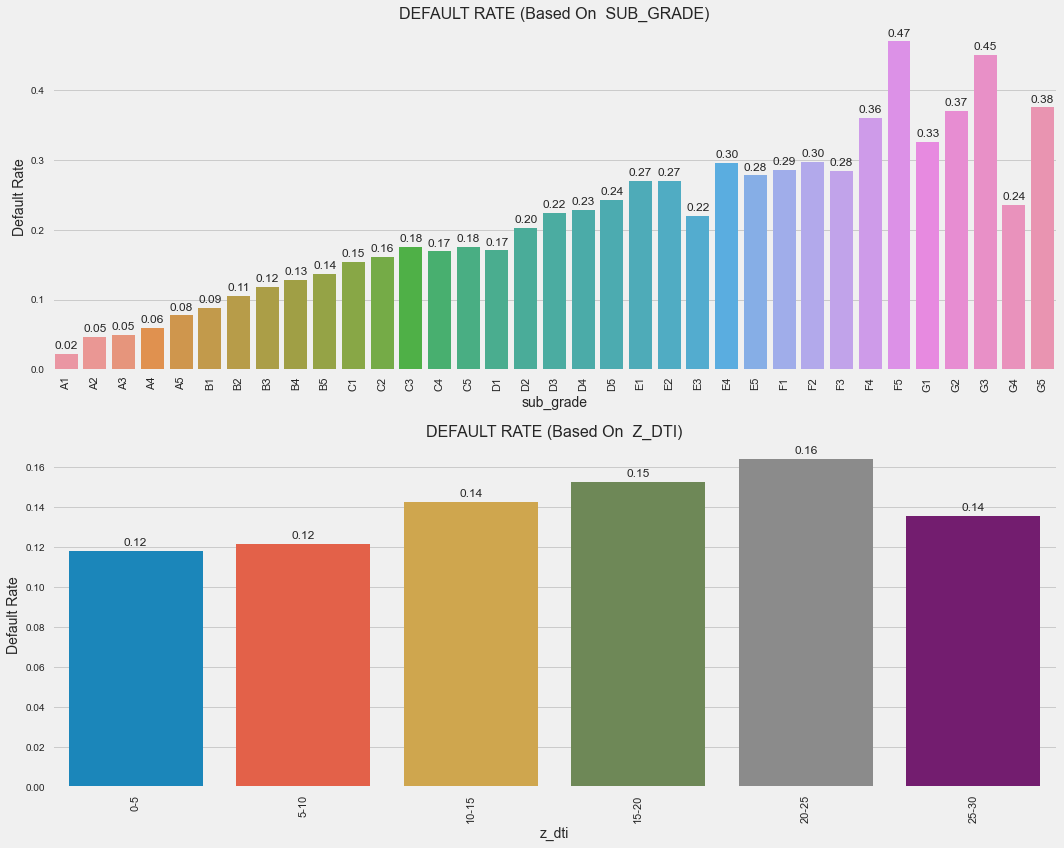

In [41]:
lst2=["sub_grade","z_dti"]
grf2(df,lst2,1, 12)

<font color='blue'>OBSERVATION & REMARKS:</font><br><b>
1. Loan Applicants having home ownership in 'Others' and 'Rent' are tend to be defaulters.<b>
2. As annnual income of applicant increases risk of loan to be default decreases
3. 'Small Business' as purpose of loan have the highest charged off percentage. Reject the loans with 'Small Business' as purpose of loans.<b>
4. Verified and Source Verified loans have higher default loans, loan verification process needs to be reviewed and audited.<b>
5. Higher term loans have more tendency to be default than lower term loans.<b>
6. Avoid givning loans  to applicant having any public record pf bankruptcies.<b>
7. A and B grade loans are safe loans. This is also supported by sub-grade.<b>


# Bivariate Analysis

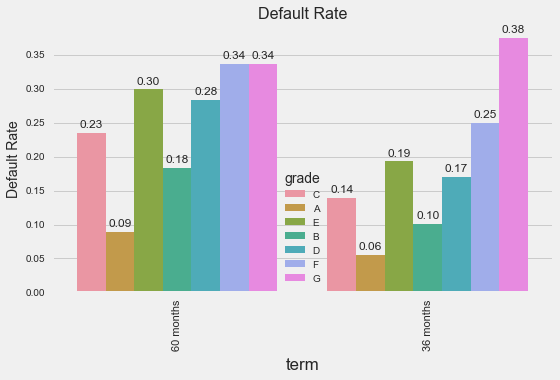

In [42]:
default_rate_bivariate(df,'term','grade')

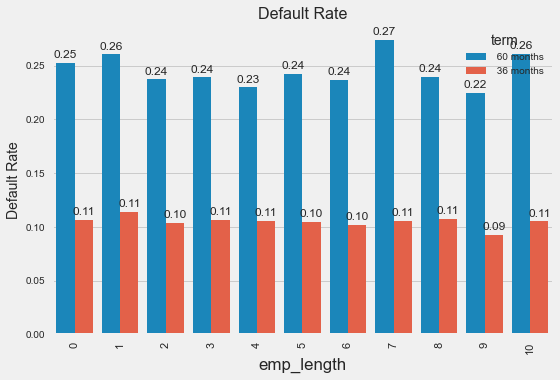

In [43]:
default_rate_bivariate(df,'emp_length','term')

#### **Loan Disbursment vs Year graph**

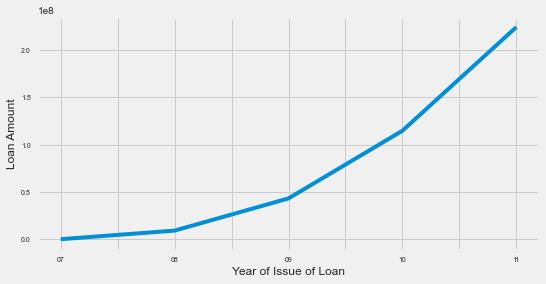

In [44]:
plt.figure(figsize=(8,4))
df.groupby('z_iss_y').loan_amnt.sum().plot(kind='line', fontsize=7)
plt.xlabel("Year of Issue of Loan", fontsize=12)
plt.ylabel("Loan Amount", fontsize=12)
plt.show()


#### **Avg. loan_amnt vs Year**

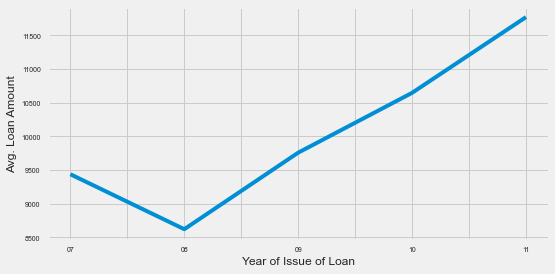

In [45]:
plt.figure(figsize=(8,4))
df.groupby('z_iss_y').loan_amnt.mean().plot(kind='line', fontsize=7)
plt.xlabel("Year of Issue of Loan", fontsize=12)
plt.ylabel("Avg. Loan Amount", fontsize=12)
plt.show()

Observation:

Average loan amount dropped sharply in 2008

#### **loan_amnt and annual_inc**

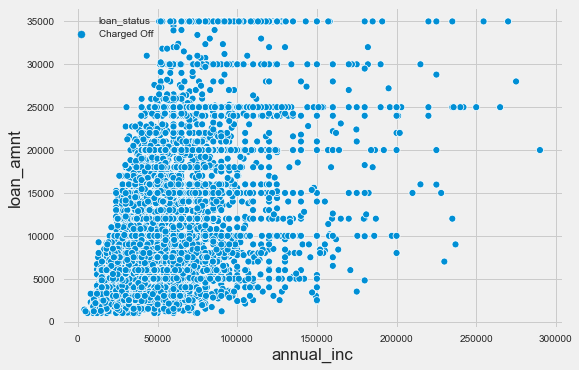

In [46]:
sns.scatterplot(x='annual_inc', y='loan_amnt',data=df[df.loan_status=='Charged Off'],hue='loan_status')
plt.show()

#### grade vs loan_amnt

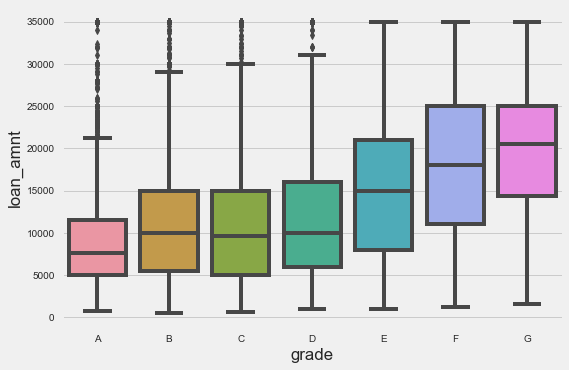

In [47]:
sns.boxplot(data=df,x='grade',y='loan_amnt',order=df.grade.value_counts().sort_index().index)
plt.show()

#### **Interest Rate and Term**

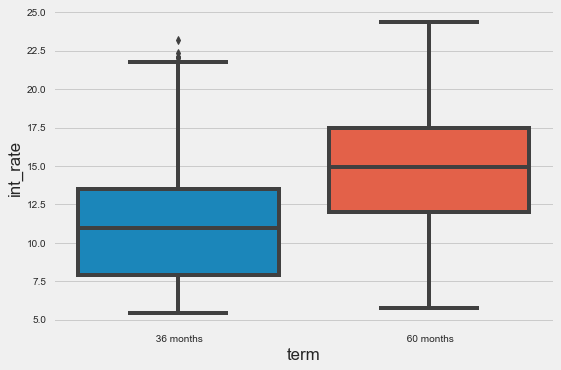

In [48]:
sns.boxplot(data=df,x='term',y='int_rate',order=df.term.value_counts().sort_index().index)
plt.show()


Observation:

Term wise interest_rate. Larger amounts were seen to be given for higher term. Ther rate of intrest associated with them is also high.

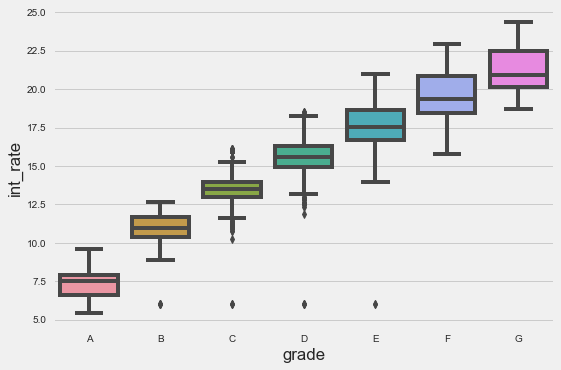

In [49]:
sns.boxplot(data=df,x='grade',y='int_rate',order=df.grade.value_counts().sort_index().index)
plt.show()

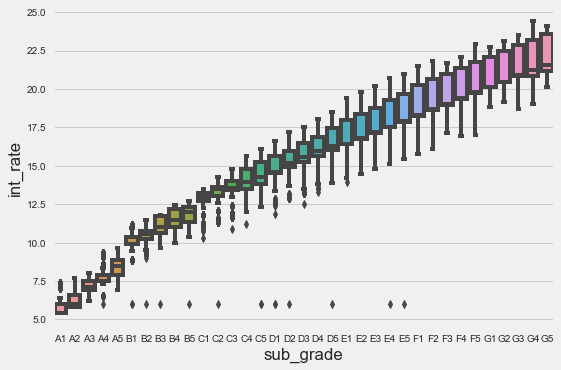

In [50]:
sns.boxplot(data=df,x='sub_grade',y='int_rate',order=df.sub_grade.value_counts().sort_index().index)
plt.show()

#### Obeservation- Lower the grades and subgrades higher the interest rate. Hence the more default loans

### Information Content Analysis

In [51]:
infm_content = pd.DataFrame(list(information_content.items()),columns=['Predictor','Information Content']) 
infm_content.sort_values(by='Information Content', ascending=False)

,Predictor,Information Content
9,sub_grade,0.45
3,grade,0.28
8,pub_rec_bankruptcies,0.26
1,z_int_rate,0.20
4,purpose,0.17
7,term,0.14
2,z_loan_amnt,0.11
0,z_annual_inc,0.08
5,home_ownership,0.06
6,verification_status,0.04
